In [424]:
# Importamos librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

In [425]:
# Extraemos datos
data="para volumen 4ta vuelta.csv"

In [426]:
#visualizamos el dataset
df= pd.read_csv(data)
df.head()

,C,Rp,Dif_vol,V_in,V_out,P_ventilador,PIP,Error_aceptable
0,20,20,-2.7,350,352.7,27.6,25.5,1
1,20,20,-4.7,350,354.7,30.3,30.2,1
2,20,20,1.2,350,348.8,32.0,33.0,1
3,20,20,3.1,400,396.9,30.3,29.4,1
4,20,20,-7.0,400,407.0,33.9,34.3,1


In [427]:
#Revisamos dimension de la data
df.shape

(69, 8)

In [428]:
#filtramos decartando columnas con datos faltantes
d_filtrado = df.dropna().copy() 

In [429]:
#Verificamos cuantos valores tenemos de Rp
d_filtrado.Rp.unique()

array([20, 50])

In [430]:
#revisamos de la data filtrada
d_filtrado.shape

(69, 8)

In [431]:
#contar valores
d_filtrado['Error_aceptable'].value_counts()

1    53
0    16
Name: Error_aceptable, dtype: int64

In [432]:
#revisamos proporción
d_filtrado['Error_aceptable'].value_counts()/len(d_filtrado)

1    0.768116
0    0.231884
Name: Error_aceptable, dtype: float64

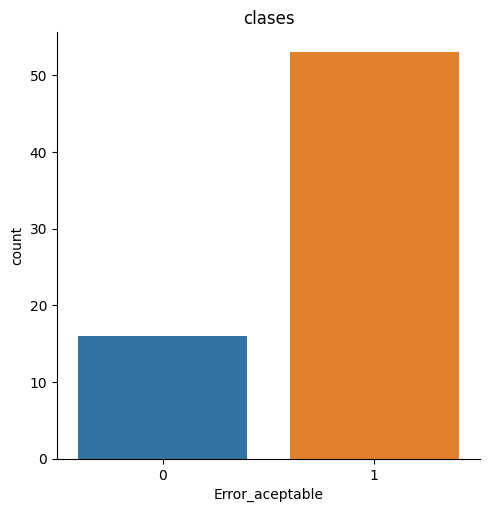

In [433]:
#observamos el desbalance de datos
p=sns.catplot(data = d_filtrado, kind ='count', x= 'Error_aceptable')
p.set(title = "clases")

In [434]:
# definimos la matriz de caracteristicas
x = d_filtrado.loc[:,['PIP','Dif_vol']]
y = d_filtrado['Error_aceptable']

In [435]:
print(len(y[y==0]))
print(len(y[y==1]))

16
53


In [436]:
#divimos la data en conjunto de entranimiento y test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 0)
print(len(x_train),len(x_test))

51 18


In [437]:
print(len(y_train[y_train==0]))
print(len(y_train[y_train==1]))


11
40


In [438]:
# Estandarización de características
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [439]:
print(df.head())

    C  Rp  Dif_vol  V_in  V_out  P_ventilador   PIP  Error_aceptable
0  20  20     -2.7   350  352.7          27.6  25.5                1
1  20  20     -4.7   350  354.7          30.3  30.2                1
2  20  20      1.2   350  348.8          32.0  33.0                1
3  20  20      3.1   400  396.9          30.3  29.4                1
4  20  20     -7.0   400  407.0          33.9  34.3                1


REGRESIÓN LOGISTICA

In [440]:
from sklearn.linear_model import LogisticRegression
regLog = LogisticRegression(random_state = 0)
regLog.fit(x_train,y_train)

LogisticRegression(random_state=0)

In [441]:
# Se anñade una columna constante para el término de intercepción
x_train_with_const = sm.add_constant(x_train)

# Crear un modelo logístico con statsmodels
logit_model = sm.Logit(y_train, x_train_with_const)

# Ajustar el modelo
result = logit_model.fit()

# Obtener los coeficientes y los p-valores
coefficients = result.params
p_values = result.pvalues

print("Coeficientes:")
print(coefficients)
print("\nP-valores:")
print(p_values)

Optimization terminated successfully.
         Current function value: 0.132089
         Iterations 11
Coeficientes:
const    7.335617
x1       1.678460
x2      -9.089223
dtype: float64

P-valores:
const    0.035622
x1       0.139185
x2       0.027574
dtype: float64


In [442]:
score = regLog.score(x_test, y_test)
round(score,4)

0.8333

In [443]:
y_pred = regLog.predict(x_test)

In [444]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.86      0.92      0.89        13

    accuracy                           0.83        18
   macro avg       0.80      0.76      0.78        18
weighted avg       0.83      0.83      0.83        18



In [445]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 3  2]
 [ 1 12]]


In [446]:
pd.crosstab(y_test,y_pred)

col_0,0,1
Error_aceptable,,
0,3,2
1,1,12


In [447]:
# K-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regLog, X = x_train, y=y_train, cv= 10)
accuracies.mean()

0.8666666666666666

In [448]:
accuracies

array([0.66666667, 1.        , 1.        , 0.8       , 1.        ,
       1.        , 1.        , 0.6       , 0.8       , 0.8       ])

<ipython-input-449-9e0b9bc40f1d>:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x_set[y_set == j,0],x_set[y_set== j,1],


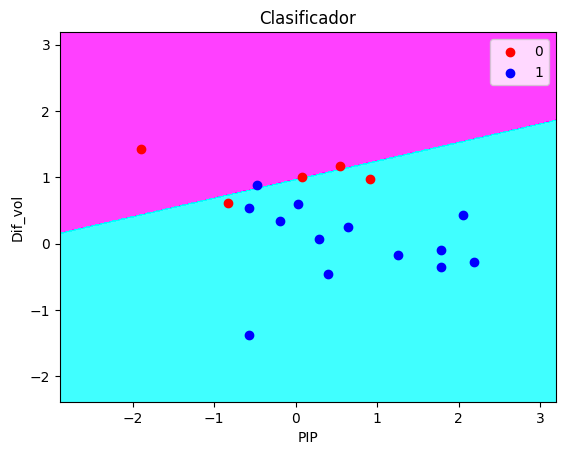

In [449]:
# Creamos un plot para ver la frontera de clasificación

from matplotlib.colors import ListedColormap
x_set, y_set = x_test, y_test
X1,X2 = np.meshgrid(np.arange(start = x_set[:,0].min()-1,stop = x_set[:,0].max()+1,step=0.01),
                    np.arange(start = x_set[:,1].min()-1,stop = x_set[:,0].max()+1,step=0.01))
plt.contourf(X1,X2, regLog.predict(np.array([X1.ravel(),X2.ravel()]).T).reshape(X1.shape),
             alpha=0.75, cmap = ListedColormap(('magenta', 'cyan')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i,j in enumerate(np.unique(y_set)):
    plt.scatter(x_set[y_set == j,0],x_set[y_set== j,1],
                c = ListedColormap(('red','blue'))(i),label = j)
    
plt.title('Clasificador')
plt.xlabel('PIP')
plt.ylabel('Dif_vol')
plt.legend()
plt.show()



**Balanceo ROS**

In [450]:
len(x_train)

51

In [451]:
train = np.concatenate([x_train, y_train.values.reshape(-1,1)], axis=1)

In [452]:
#transformamos a un dataFrame
train = pd.DataFrame(train,columns=['PIP','Dif_vol','Error_aceptable'])

In [453]:
#obtenemos la clase con error que no se acepta
train_class_0 = train.query("Error_aceptable == 0")
train_class_0.head()

,PIP,Dif_vol,Error_aceptable
10,0.439871,1.052039,0.0
12,1.027543,1.087821,0.0
13,-1.064570,0.616145,0.0
16,-1.691421,1.953103,0.0
20,-0.845173,0.528316,0.0


In [454]:
train_class_0.shape

(11, 3)

In [455]:
n_class0 = len(train.query("Error_aceptable == 0"))
n_class1 = len(train.query("Error_aceptable == 1"))
print ( n_class0, n_class1)

11 40


In [456]:
i_class0_downsampled = train_class_0.sample(n_class1,replace = True)
len(i_class0_downsampled)

40

In [457]:
new_train = pd.concat([train.query("Error_aceptable == 1"), i_class0_downsampled], axis=0)
new_train[['Error_aceptable']].value_counts()

Error_aceptable
0.0                40
1.0                40
dtype: int64

In [458]:
new_x_train =new_train.loc[:,['PIP','Dif_vol']].values
new_y_train =new_train.loc[:,['Error_aceptable']].values


In [459]:
new_y_train = pd.Series(new_y_train.reshape(-1,))

In [460]:
new_train.loc[:,['Error_aceptable']].value_counts()

Error_aceptable
0.0                40
1.0                40
dtype: int64

Nuevo modelo con nueva data

In [461]:
model= LogisticRegression()
model. fit(new_x_train, new_y_train)

LogisticRegression()

In [462]:
y_pred2 = model.predict(x_test)

In [463]:
print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.86      0.92      0.89        13

    accuracy                           0.83        18
   macro avg       0.80      0.76      0.78        18
weighted avg       0.83      0.83      0.83        18

              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.77      0.87        13

    accuracy                           0.83        18
   macro avg       0.81      0.88      0.82        18
weighted avg       0.90      0.83      0.84        18

